# Get data

In [66]:
import csv
from itertools import count
import sys

import requests
from requests.auth import HTTPBasicAuth


PER_PAGE = 500
USER = "!!!CENSORED!!!"
PASS = ""
URL = "https://docraptor.com/docs.json?per_page=1000&page=1000"


DOC_KEYS = [
    "async",
    "created_at",
    "document_type",
    "domain_id",
    "id",
    "ip_address",
    "javascript",
    "name",
    "tag",
    "test",
    "updated_at",
    "user_id"]


def get_a_page_of_documents(page, per_page=PER_PAGE):
    r = requests.get(
        URL,
        params={"per_page": per_page, "page": page},
        headers={"accept": "application/json"},
        auth=HTTPBasicAuth(USER, PASS))
    return r.json()


def get_all_docs():
    page = count(start=1)
    while True:
        page_data = get_a_page_of_documents(next(page))
        if len(page_data) == 0:
            return
        for doc in page_data:
            yield doc


def as_csv(filename):
    with open(filename, 'wt') as f:
        writer = csv.writer(f)
        writer.writerow(CSV_KEYS)
        for doc in get_all_docs():
            writer.writerow([doc[k] for k in CSV_KEYS])

In [67]:
# downloads document records from docraptor and saves to CSV
import time

start = time.time()
as_csv("docraptor_docs.csv")
print("time: {}".format(time.time() - start))

time: 275.25133895874023


# Look at data

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [83]:

# ignoring empty columns like tags, etc; update_at (same as created_at); async, javascript (always True, False)
docs = pd.read_csv(
    "docraptor_docs.csv",
    usecols=["created_at", "id", "ip_address", "test"],
    parse_dates=["created_at"], infer_datetime_format=True)
first = docs[["created_at"]].min()[0]
last = docs[["created_at"]].max()[0]
print("{} records over {}".format(len(docs), last - first))
docs[:2]

155269 records over 725 days 04:08:52


,created_at,id,ip_address,test
0,2018-06-22 14:52:18,66293362,178.128.166.6,True
1,2018-06-22 14:52:13,66293354,178.128.166.6,True


# Split by 'test' flag

In [84]:
test = docs.drop(docs[docs.test == False].index)
production = docs.drop(docs[docs.test == True].index)
print("Test docs: {}, Production: {}".format(len(test), len(production)))

Test docs: 152868, Production: 2401


# Top IPs

In [6]:
def top_ips(df, top=10):
    return df[["ip_address", "id"]].groupby(
        by="ip_address").count().rename(
        columns={"id": "count"}).sort_values("count", ascending=False)[:top]

In [7]:
top_ips(production)

,count
ip_address,
138.68.184.166,1772
35.158.216.151,136
193.240.196.130,97
46.101.5.181,97
89.35.221.4,79
46.101.58.201,76
52.90.70.101,64
178.62.107.172,37
206.189.114.122,12


In [8]:
top_ips(test)

,count
ip_address,
138.68.184.166,14479
138.68.188.134,4134
46.101.92.238,3972
46.101.74.235,3804
46.101.5.181,3444
188.166.171.211,3428
89.35.221.4,3243
188.166.170.47,3088
138.68.191.148,2475


## Note

Note how most "production" documents are still from the same IP where most of the test ones are generated from. This could hint they're still test documents but with the test flag set to false.

# Time series

In [ ]:
# freq can be e.g. '5m', "H'
def create_date_range_for(df, freq="5m"):
    return pd.date_range(df[["created_at"]].min()[0], df[["created_at"]].max()[0], freq=freq)

In [56]:
production_per_half_hour = pd.DataFrame({"count": 1}, index=production['created_at']).resample('30Min').count()
count = production_per_half_hour['count']

In [57]:
len(count) 

34565

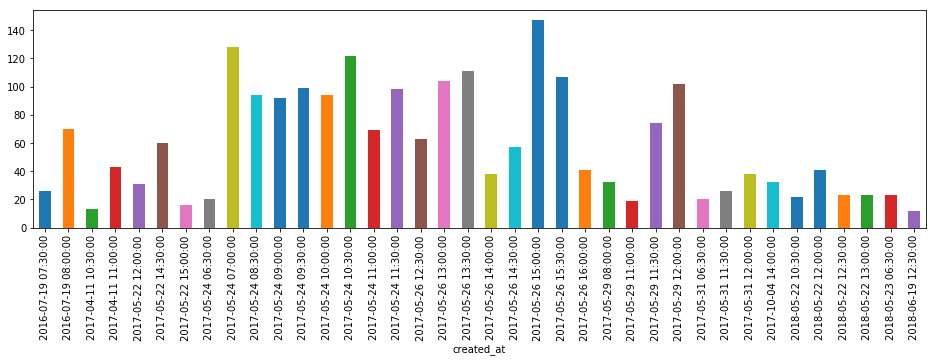

In [65]:
count[count > 10].plot.bar(figsize=(16,4))

In [61]:
production1 = production[production.ip_address != '138.68.184.166']
production_per_half_hour1 = pd.DataFrame({"count": 1}, index=production1['created_at']).resample('30Min').count()
count1 = production_per_half_hour1['count']

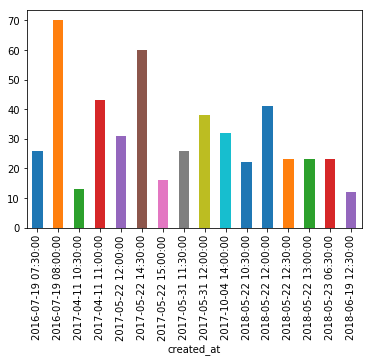

In [62]:
count1[count1 > 10].plot.bar()